## Introduction

An example of node classification on a homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

**1.** Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

import pymc3 as pm  # for probabilistic programming
import theano
import theano.tensor as tt

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

%matplotlib inline

/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = "~/data/cora"

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx = max(nx.connected_component_subgraphs(g_nx, copy=True), key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


### The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are,

1. Use 2nd order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm, [2], is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [1] for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0.

In [4]:
rw = BiasedRandomWalk(StellarGraph(g_nx))

walks = rw.run(nodes=list(g_nx.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=10,        # number of random walks per root node 
               p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=2.0        # Defines (unormalised) probability, 1/q, for moving away from source node
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


### Representation Learning using Word2Vec

We use the `Word2Vec`, [2], implementation in the free Python library `Gensim`, [3], to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [6]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv['19231'].shape

(128,)

### Visualise Node Embeddings

We retrieve the `Word2Vec` node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [7]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx.node[node_id]['subject'] for node_id in node_ids]

In [8]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

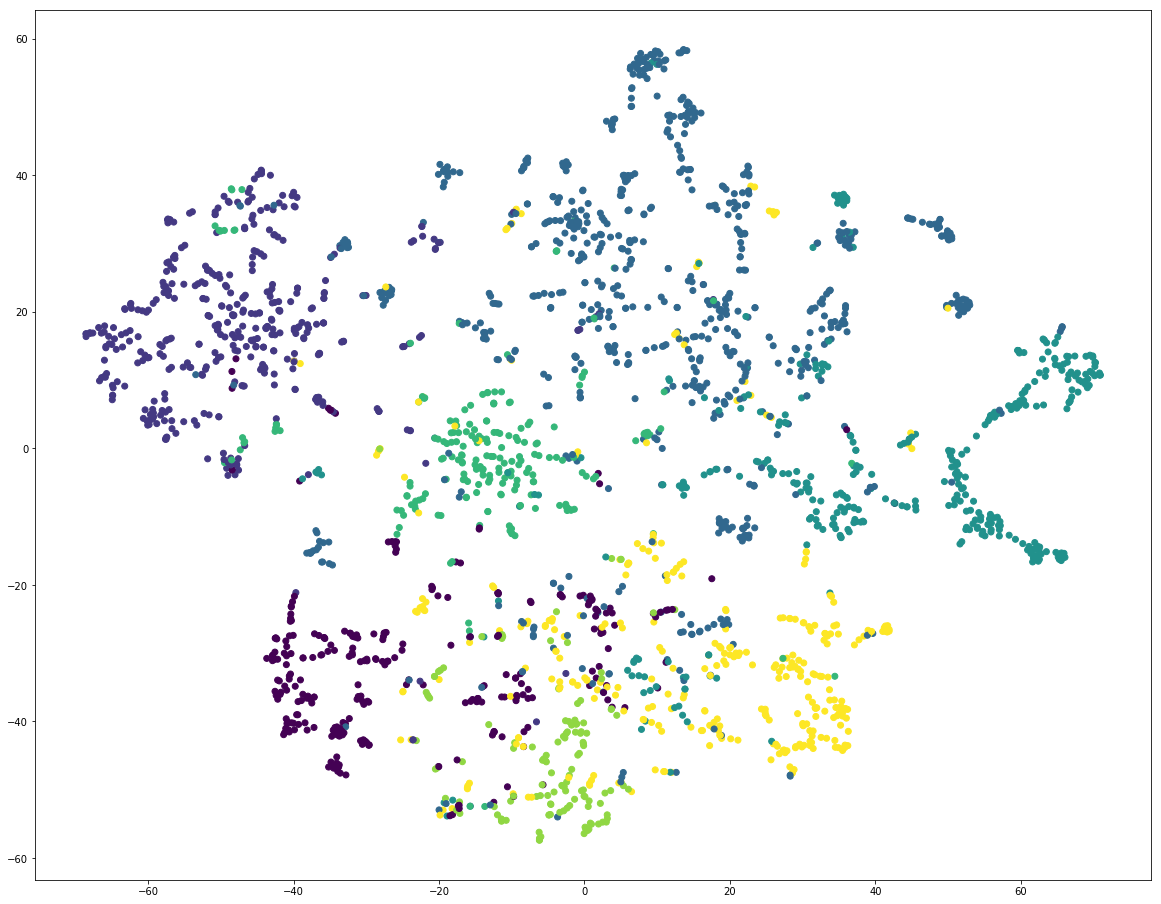

In [9]:
# draw the points
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours)

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [10]:
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)

We will reduce the dimensionality of the input data to 8 dimensions. 

We do this to make training the Bayesian model faster since we have to estimate the posterior distributions of fewer parameters.

In [296]:
n_components = 64
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(2485, 64)


### Data Splitting

We split the data into train and test sets. 

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.75, test_size=None)

In [298]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 64)
 y_train = (1863,)
 X_test = (622, 64)
 y_test = (622,)


### Classifier Training

First, we train a standard Logistic Regression classifier on the training data. 

In [299]:
clf = LogisticRegressionCV( Cs=10, 
                            cv=10, 
                            scoring="accuracy",
                            verbose=False,
                            multi_class='ovr')
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=False)

Predict the hold out test set.

In [300]:
y_pred = clf.predict(X_test)

### Accuracy of standard Logistic Regression

Calculate the accuracy of the classifier on the test set.

In [301]:
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression accuracy: {}".format(accuracy_lr))

Logistic Regression accuracy: 0.8231511254019293


### Bayesian Classifier Training

Next, we train a Bayesian Logistic Regression classifier.

First we need to map the labels in 'y' to integers in the range 0...6 since there are 7 subjects in Cora

In [302]:
subjects = np.unique(y)
subject_mapper = { subject: i for i, subject in enumerate(subjects) }
subject_mapper

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [303]:
inv_subject_mapper = {v: k for k, v in subject_mapper.items()}

In [304]:
y_train_cat = np.array([ subject_mapper[subject] for subject in y_train])
y_test_cat = np.array([ subject_mapper[subject] for subject in y_test])
y_test_cat[:10]

array([4, 3, 3, 4, 1, 1, 2, 6, 1, 2])

Bayesian Logistic Regression model in PyMC3 from https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [305]:
n_total = X_train.shape[0]  # number of data points
n_out = 7  # number of outcome categories
n_x = n_components  # number of predictors

### Bayesian model specification

In [306]:
# make these shared variables such that we can replace them with the test data later on.
Xt = theano.shared(X_train)
yt = theano.shared(y_train_cat)

with pm.Model() as blr_model:    
    # Creating the model
    beta = pm.Normal('beta', mu=0, sd=10, shape=(n_x, n_out))    
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=n_out)  # 7 subjects
    # alpha = pm.Flat('alpha', shape=(n_out,))
    #mu = tt.dot(Xt, beta) + alpha
    p = tt.nnet.softmax(Xt.dot(beta) + alpha)
    # p = pm.Deterministic('p', tt.nnet.softmax(mu))
    
    y_obs = pm.Categorical('y', p=p, observed=yt)

### Model training with MCMC

Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
  5%|▌         | 130/2500 [00:40<13:14,  2.98it/s]/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


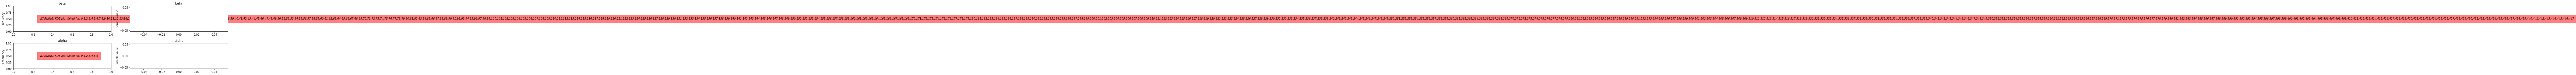

In [307]:
with blr_model:
    step = pm.NUTS()  # Metropolis is much faster but it does not converge!
    #db = pm.backends.Text('test')  #.Text('test')
    trace = pm.sample(draws=2000, step=step, chains=2, cores=1)

    pm.traceplot(trace)

In [24]:
#res = pm.plot_posterior(trace)

### Bayesian predictions

Now, we predict the test set, $X_{test}$. 

The **trace** variable holds the posterior samples for each parameter's marginal distribution.

In order to make a prediction (remember that we have one model for predicting each subject) we take one sample from the parameter posteriors for each model and then use it to predict the probability of that subject given the input features, $X_{test}$. We do this for all samples from the parameter posterior and all model in order to obtain a distribution of predictions.

In [25]:
np.concatenate( (trace[0]['beta'][:, 0], [trace[0]['alfa'][0]]) )

array([-3.66104026,  0.06262266,  0.25890785,  6.32014194, -3.77176264,
       -2.56206584,  3.50084921])

In [348]:
def collect_posterior_samples(trace, model_index, beta='beta', alpha='alfa'):
    betas = np.array([ samples[beta][:, model_index] for samples in trace])
    alphas = np.array([ [samples[alpha][model_index]] for samples in trace])

    return betas, alphas

def predict(x, betas, alphas):
    y_pred = np.matmul(x, np.transpose(betas)).reshape(-1, 1) + np.array(alphas)
    # y_pred.shape
    y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    #print(y_pred.shape)
    
    return y_pred

def predict_subject(x, trace, probs=False, beta='beta', alpha='alfa'):
    counts = np.zeros(7)
    for tr in trace:
        B = tr[beta]
        a = tr[alpha]
        preds = np.matmul(x, B) + a
        if probs:
            preds = 1.0 / (1.0 + np.exp(-preds))
        counts[np.argmax(preds)] += 1
    return counts

In [27]:
model_index = 3
# Posterior samples of model parameters for predicting the 0th subject
model_betas, model_alphas = collect_posterior_samples(trace, model_index=model_index)

In [28]:
print(len(model_betas))
print(len(model_alphas))

2000
2000


In [29]:
X_test.shape

(622, 6)

In [30]:
print(model_betas.shape)
print(model_alphas.shape)

(2000, 6)
(2000, 1)


In [31]:
model_betas = [ (collect_posterior_samples(trace, model_index=model_index))[0] for model_index in range(7)]
model_alphas = [ (collect_posterior_samples(trace, model_index=model_index))[1] for model_index in range(7)]

In [32]:
y_pred = [ predict(x=X_test[0, :], betas=betas, alphas=alphas) for betas, alphas in zip(model_betas, model_alphas)]

(2000, 1)
(2000, 1)
(2000, 1)
(2000, 1)
(2000, 1)
(2000, 1)
(2000, 1)


In [33]:
len(y_pred)

7

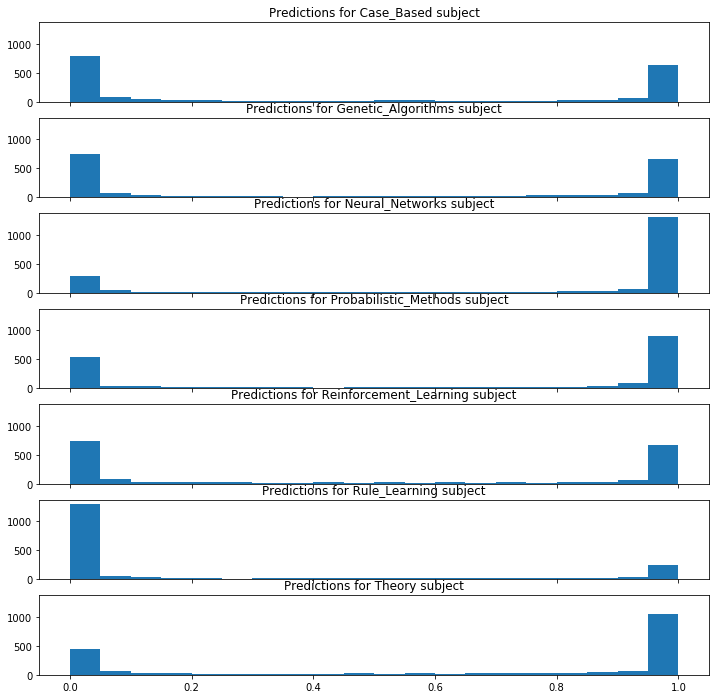

In [34]:
f, ax = plt.subplots(len(y_pred), figsize=(12, 12), sharex=True, sharey=True)
#f.suptitle('probability')
for i in range(len(y_pred)):
    ax[i].hist(y_pred[i], bins=20)
    ax[i].set_title("Predictions for {} subject".format(inv_subject_mapper[i]))
    

Text(0.5,1,'Predictions for Probabilistic_Methods subject')

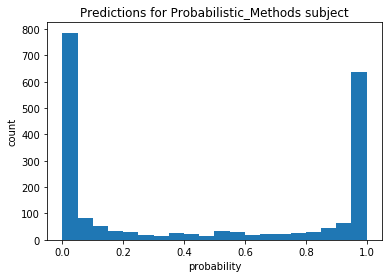

In [35]:
res = plt.hist(y_pred[0], bins=20)
plt.xlabel('probability')
plt.ylabel('count')
plt.title("Predictions for {} subject".format(inv_subject_mapper[model_index]))

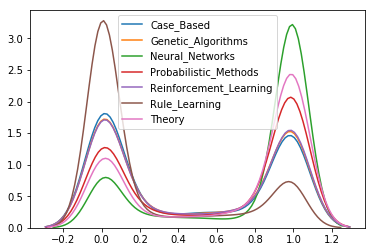

In [37]:
for i in range(len(y_pred)):
    sns.kdeplot(data=y_pred[i].reshape((-1,)), label=inv_subject_mapper[i])

### What is a better way to visualize the above predictions?

For each sample of model parameters, get the model that predicts the subject with the highest probability and record it. Then plot a histogram of the times each model won for this query? 

Is this useful way of visualising the Bayesian model's predictions?

In [38]:
print(trace[0]['beta'].shape)
print(trace[0]['alfa'].shape)
print(X_test[0].shape)

(6, 7)
(7,)
(6,)


In [39]:
x = X_test[0].reshape(1,-1)
print(x.shape)
B = trace[0]['beta']
print(B.shape)

(1, 6)
(6, 7)


In [40]:
y_pred = np.matmul(x, B) # + np.array(alphas)
print(y_pred.shape)
# y_pred.shape
y_pred = 1.0 / (1.0 + np.exp(-y_pred))
y_pred

(1, 7)


array([[0.87312533, 0.86399769, 0.99890939, 0.9869559 , 0.90341835,
        0.80312904, 0.99649586]])

In [41]:
p = np.argmax(y_pred)
inv_subject_mapper[p]

'Neural_Networks'

In [42]:
np.zeros(7).shape

(7,)

In [57]:
test_point_index = 20
counts = predict_subject(X_test[test_point_index], trace)
print(counts)
print("Subject predicted: {} vs true subject: {}".format(inv_subject_mapper[np.argmax(counts)], y_test[test_point_index]))

[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.999e+03 0.000e+00]
Subject predicted: Rule_Learning vs true subject: Rule_Learning


<BarContainer object of 7 artists>

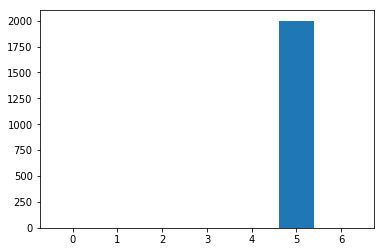

In [58]:
plt.bar(range(len(counts)), height=counts)

Predict all the test points and compare accuracy with regards to ground truth.

In [46]:
y_pred = []
for x in X_test:
    counts = predict_subject(x, trace)
    y_pred.append(inv_subject_mapper[np.argmax(counts)])
len(y_pred)

622

### Accuracy of Bayesian Logistic Regression

In [47]:
accuracy_blr = accuracy_score(y_test, y_pred)
print("Bayesian Logistic Regression accuracy: {}".format(accuracy_blr))

Bayesian Logistic Regression accuracy: 0.747588424437299


### Compare the accuracies of the two models

In [48]:
print("Logistic Regression accuracy is {:.3f} vs Bayesian Logistic Regression accuracy {:.3f}".format(accuracy_lr, accuracy_blr))

Logistic Regression accuracy is 0.664 vs Bayesian Logistic Regression accuracy 0.748


### Bayesian model training with VI

In [309]:
with blr_model:
    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

Let's setup monitoring of the train and test set accuracies during training. 

In [310]:
test_ok = tt.eq(test_probs.argmax(-1), y_test_cat)
train_ok = tt.eq(train_probs.argmax(-1), y_train_cat)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

In [311]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

### Now do inference by calling fit()

In [312]:
 svgd_approx = inference.fit(100, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker])

100%|██████████| 100/100 [01:04<00:00,  1.11it/s]


#### Plot the train and test set accuracies for each training step.

/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5,1,'Training Progress')

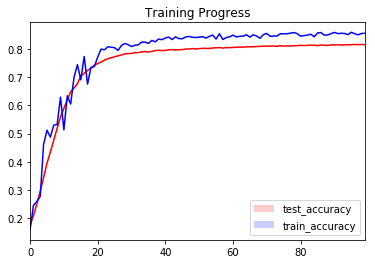

In [313]:
sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red')
sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue')
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress')

In [314]:
test_accuracy.eval()

array([0.81189711, 0.81832797, 0.81189711, 0.81672026, 0.82475884,
       0.81028939, 0.81511254, 0.80385852, 0.82797428, 0.80868167,
       0.81832797, 0.81189711, 0.82315113, 0.81511254, 0.81350482,
       0.81350482, 0.81993569, 0.81189711, 0.81832797, 0.82475884,
       0.81672026, 0.81672026, 0.81832797, 0.81511254, 0.81511254,
       0.81993569, 0.80707395, 0.82475884, 0.82475884, 0.81832797,
       0.82636656, 0.81189711, 0.81511254, 0.82315113, 0.81832797,
       0.81350482, 0.81672026, 0.81028939, 0.81672026, 0.81189711,
       0.81350482, 0.81350482, 0.82315113, 0.82315113, 0.81189711,
       0.81189711, 0.81672026, 0.82315113, 0.81672026, 0.81993569,
       0.81511254, 0.81350482, 0.81672026, 0.81511254, 0.81511254,
       0.82475884, 0.81189711, 0.81511254, 0.81511254, 0.81511254,
       0.81832797, 0.81672026, 0.82154341, 0.82475884, 0.81511254,
       0.82154341, 0.80546624, 0.81350482, 0.81672026, 0.81350482,
       0.80546624, 0.81511254, 0.82475884, 0.81993569, 0.82315

In [315]:
train_accuracy.eval()

array(0.86366076)

In [316]:
beta_samples = svgd_approx.sample_node(beta, size=200)
alpha_samples = svgd_approx.sample_node(alpha, size=200)
betas = beta_samples.eval()
alphas = alpha_samples.eval()

In [317]:
betas.shape

(200, 64, 7)

In [318]:
alphas.shape

(200, 7)

In [266]:
gr = pm.plot_posterior(svgd_approx.sample(2000))

ValueError: Image size of 864x81360 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10ff6d2f0> (for post_execute):


ValueError: Image size of 864x81360 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 864x81360 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x81360 with 904 Axes>

In [319]:
ppc = pm.sample_approx(svgd_approx,draws=1000)

In [320]:
ppc

<MultiTrace: 1 chains, 1000 iterations, 2 variables>

In [321]:
y_pred = []
for x in X_test:
    counts = predict_subject(x, trace=ppc, beta='beta', alpha='alpha')
    y_pred.append(inv_subject_mapper[np.argmax(counts)])
len(y_pred)

622

In [322]:
accuracy_blr_vi = accuracy_score(y_test, y_pred)
print("Bayesian Logistic Regression accuracy (VI): {}".format(accuracy_blr_vi))

Bayesian Logistic Regression accuracy (VI): 0.8183279742765274


In [331]:
test_point_index = -50
counts = predict_subject(X_test[test_point_index], ppc, probs=True, alpha='alpha')
print(counts)
print("Subject predicted: {} vs true subject: {}".format(inv_subject_mapper[np.argmax(counts)], y_test[test_point_index]))

[   0.    0. 1000.    0.    0.    0.    0.]
Subject predicted: Neural_Networks vs true subject: Neural_Networks


<BarContainer object of 7 artists>

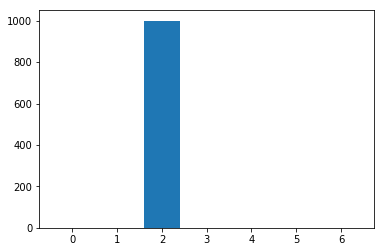

In [332]:
plt.bar(range(len(counts)), height=counts)

In [344]:
model_betas = [ (collect_posterior_samples(ppc, model_index=model_index, alpha='alpha'))[0] for model_index in range(7)]
model_alphas = [ (collect_posterior_samples(ppc, model_index=model_index, alpha='alpha'))[1] for model_index in range(7)]

In [345]:
y_pred = [ predict(x=X_test[test_point_index, :], betas=betas, alphas=alphas) for betas, alphas in zip(model_betas, model_alphas)]

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


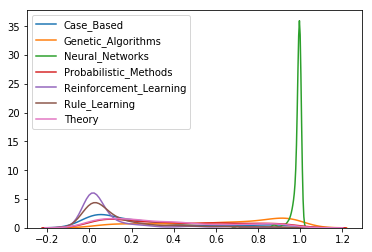

In [346]:
for i in range(len(y_pred)):
    sns.kdeplot(data=y_pred[i].reshape((-1,)), label=inv_subject_mapper[i])

### Compare the accuracies of the two models

In [347]:
print("Logistic Regression accuracy is {:.3f} vs Bayesian Logistic Regression (VI) accuracy {:.3f}".format(accuracy_lr, accuracy_blr_vi))

Logistic Regression accuracy is 0.823 vs Bayesian Logistic Regression (VI) accuracy 0.818
